<a href="https://colab.research.google.com/github/higebobo/my-colab/blob/main/Algorithmic_Trading_with_MACD_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithmic Trading with MACD in Python

A step-by-step guide to implementing a powerful strategy

本スクリプトは以下のサイトで紹介されている手法を改変したものである。

[Algorithmic Trading with MACD in Python
A step\-by\-step guide to implementing a powerful strategy](https://medium.com/codex/algorithmic-trading-with-macd-in-python-1c2769a6ad1b)

## Step-1 準備

### ライブラリのインストール

In [ ]:
!pip install japanize_matplotlib requests_cache urllib3
!pip install --upgrade pandas-datareader

     |████████████████████████████████| 4.1 MB 6.9 MB/s 
     |████████████████████████████████| 47 kB 5.5 MB/s 
     |████████████████████████████████| 138 kB 54.7 MB/s 
     |████████████████████████████████| 127 kB 29.3 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=008d93cad8b6f84b20e7397fa1edb6a25acdf170c830a22c1d1b49f9c1926bbe
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |███████████████

### インポート

In [ ]:
import datetime

import japanize_matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as pdr
from requests_cache import CachedSession

### パラメータの設定

### チャートオプション

In [ ]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams["font.family"] = 'IPAexGothic'
plt.style.use('fivethirtyeight')

#### 銘柄リスト

In [ ]:
symbol_map = {
    'AAPL': 'Apple Inc.',
    'MSFT': 'Microsoft  Corporation',
    '7203.T': 'トヨタ自動車',
    '9104.T': '商船三井',
    '9434.T': 'ソフトバンク'
}

#### 対象の銘柄と期間を指定

In [ ]:
# ここに対象となる銘柄コードを設定する(米国株の場合はティッカー、東証の場合は銘柄コードの末尾に.Tを付加)
symbol = '9434.T'
symbol = 'AAPL'

# 算出期間を週で指定
weeks = 52

end = datetime.date.today()
start = end - datetime.timedelta(weeks=weeks)

## Step-2: データの取得

In [ ]:
# 取得データをキャッシュする
expire_after = datetime.timedelta(days=3) # 3日間キャッシュする
session = CachedSession(cache_name='cache', backend='sqlite', 
                        expire_after=expire_after) 
session.headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
    'Accept': 'application/json;charset=utf-8'}

df = pdr.DataReader(symbol, 'yahoo', start, end, session=session)
# df = pdr.DataReader(symbol.replace('.T', '.JP'), 'stooq', start, end, session=session)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-04-19,167.820007,163.910004,165.020004,167.399994,67723800.0,167.399994
2022-04-20,168.880005,166.100006,168.759995,167.229996,67929800.0,167.229996
2022-04-21,171.529999,165.910004,168.910004,166.419998,87227800.0,166.419998
2022-04-22,167.869995,161.500000,166.460007,161.789993,84775200.0,161.789993
2022-04-25,163.169998,158.460007,161.119995,162.880005,92824080.0,162.880005


## Step-3: MACDの算出

In [ ]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

In [ ]:
macd = get_macd(df['Close'], 26, 12, 9)
macd.tail()

,macd,signal,hist
Date,,,
2021-04-30,0.093954,-0.893475,0.987429
2021-04-29,0.466175,-0.621545,1.087720
2021-04-28,0.760465,-0.345143,1.105608
2021-04-27,1.046186,-0.066877,1.113063
2021-04-26,1.284444,0.203387,1.081057


## Step-4: MACDのプロット

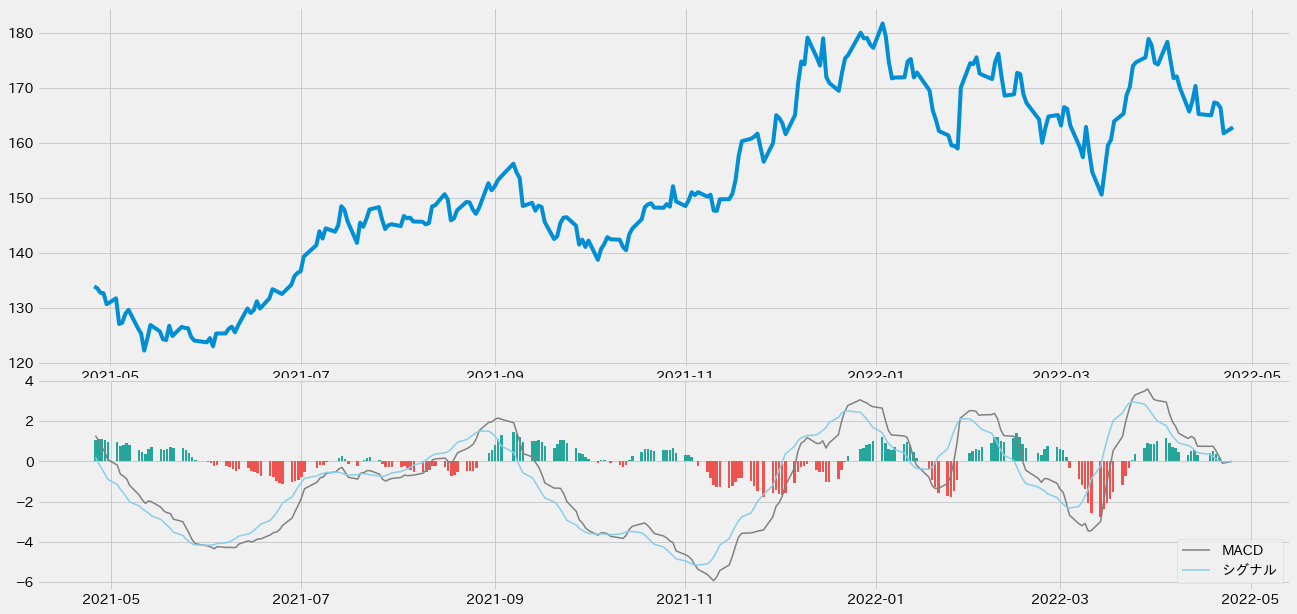

In [ ]:
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan=3, colspan=1)

    ax1.plot(prices)
    ax2.plot(macd, color='grey', linewidth=1.5, label='MACD')
    ax2.plot(signal, color='skyblue', linewidth=1.5, label='シグナル')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color='#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color='#26a69a')

    plt.legend(loc='lower right')

plot_macd(df['Close'], macd['macd'], macd['signal'], macd['hist'])

## Step-5: トレード戦略の作成

戦略として挙げられている

```
IF MACD LINE > SIGNAL LINE => BUY THE STOCK
IF SIGNAL LINE > MACD LINE => SELL THE STOCK
```

MACDがシグナルを越えたら買い、シグナルがMACDを越えたら売りというもの

In [ ]:
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = implement_macd_strategy(df['Close'], macd)

## Step-6: 売買シグナルのプロット

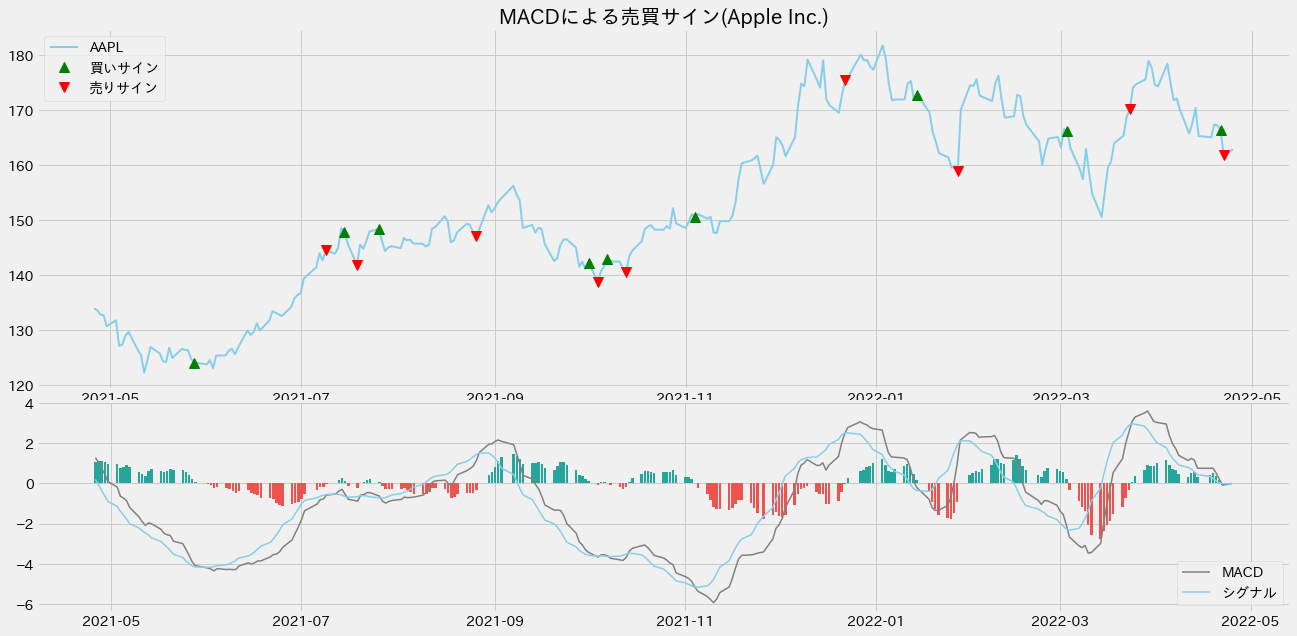

In [ ]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan=3, colspan=1)

ax1.plot(df['Close'], color='skyblue', linewidth=2, label=symbol)
ax1.plot(df.index, buy_price, marker='^', color='green', markersize=10, label='買いサイン', linewidth=0)
ax1.plot(df.index, sell_price, marker='v', color='r', markersize=10, label='売りサイン', linewidth=0)
ax1.legend()
ax1.set_title(f'MACDによる売買サイン({symbol_map.get(symbol)})')
ax2.plot(macd['macd'], color='grey', linewidth=1.5, label='MACD')
ax2.plot(macd['signal'], color='skyblue', linewidth=1.5, label='シグナル')

for i in range(len(macd)):
    if str(macd['hist'][i])[0] == '-':
        ax2.bar(macd.index[i], macd['hist'][i], color='#ef5350')
    else:
        ax2.bar(macd.index[i], macd['hist'][i], color='#26a69a')
        
plt.legend(loc='lower right')
plt.show()